<a href="https://colab.research.google.com/github/lpceronm/QKD/blob/master/Quantum_Key_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Quantum Key Distribution

#####[Github Repository](https://github.com/lpceronm/QKD)

* Laura Cerón Martínez.
* Oscar Martínez  Rodríguez.
* Valentina Marulanda Acosta.

---



# Objectives


1. Comprehend the principles of Quantum Key Distribution protocols.
2. Simulate the funciontioning of the SSP protocol.
3. llustrate the imact and consecuences of noise in a quantum channel on the key distribution process.
4. Understand the efforts of quantum hackers.
  


# Introduction

Cryptography aims to communicate data between authorized entities in a secure way, in fact the encryption era started a century ago with the *One-Time pad* proposed by Vernam which uses a symmetric one-use key shared between a sender and a receiver, this means that both parties use the same *secret key* to encrypt and decrypt messages. In this schemas the data remains secure as long as the key remains secret.  

To ensure the secrecy of the keys, nowadays, several key distribution protocols are used to create and securly exchange the these keys between parties, among them the *Diffie Helman* algorithm is one of the most used in today’s applications. This algorithm uses the properties of prime numbers and modular exponentiation to compute the keys. It bases its security in the fact that the discrete logarithm is extremely difficult to compute. 

As the DH algorithm, most of the existing KD protocols base their security in the computational complexity of their calculations and given the fact that computing power of our machines is constantly increasing this complexity is no longer enough. This is where quantum properties come to play. The QKD protocols provide a solution to the key distribution problem which relies entirely upon the immutable laws of physics. 

## QKD

In a QKD system, first studied by Stephen Weisner (1970s), an eavesdropper could be easily detected thanks to the observation errors its measurements introduce to the quantum channel. Nowadays commercial QKD networks are aimed mainly for governments and corporations with high security requirements, however they are currently limited  to short links specially because of problems in the physical layer.

The basic scheme of a quantum key distribution consists of two *authorized partners* sharing information over a classical channel and establishing the secret key with a quantum connection (usually optical fiber).  The partners are traditionally called **Alice** and **Bob**, in case of a third part trying to intercept the communication it is named **Eve** for eavesdropper.

<center><img src="https://i.postimg.cc/rmKK355x/QKD.jpg" alt="basis"></center>

<h4><center><i>Img 1: </i>Basic schema of a QKD protocol</center></h4>

The QKD by deffinition tracks Eve, any attempt to measure modifies the state of the measured system. If the eavesdropper interferes the quantum channel it has to recreate the states in order to send them to Bob since the qubit is destroyed when measured. Protocols define a tolerance threshold for the error rate. Error rate is susceptible to eavesdropping, the effect of Eve is now detectable and communication could be restarted if needed. Alternatively if Eve wants to copy the key duplicating the states for further processing this is proven impossible by the non-clonning theorem (Wootters and Zurek, 1982) which makes the quantum channel robust.

There are three main families of explicit QKD protocols: discrete-variable coding, continuous-variable coding, and more recently distributed phase-reference coding, the most significant difference is the scheme detection. In this project we will focus in the well-known discrete-variable protocol BB84 and some of its variations  







## Discrete Variable Protocols

### BB84 protocol

BB84 is one of the best known QKD discrete-variable protocol developed by Charles Bennet and Gilles Brassard in 1984. In order to construct a common key with Bob, Alice encripts bits of information by imposing a certain polarization on a photon and sending it to Bob via the quantum channel. In order to do this she may choose one out of two basis each with two orthogonal states. The basis used for this protocol are the standard basis, composed of the eigenstates of the *Z* Pauli matrix: $|0\rangle$ and $|1\rangle$, and the Hadammard basis,  composed of the eigenstates of the *X* Pauli matrix: $|+\rangle$ and $|-\rangle$. The principle of this protocol can be summarized in the following steps:



1.   First, Alice will generate a random sequence of bits to be encoded and sent to Bob.
2.   Next, for each of the bits Alice will choose one of the basis at random, polarize a photon in one of the two states and then send that photon to Bob. For example if Alice's bit is '0'  and she chose the standard basis, she will send a photon with the $|0\rangle$ state, if the bit is '1', she will polarize it with the $|1\rangle$ state.
3. Bob will then receive the polarized photon or qubit and will choose at random (and independently for each qubit) one of the two basis to measure it. If it measures the bit with the same basis Alice has encoded it, he will correctly deduce whether Alice sent a '0'  or a '1'. However, if it chooses the wrong basis the resulting bit has a 50% chance of coinciding with the one Alice sent. The series of bits Bob has decoded is now called the *raw key*.

 <a href="https://iqe.pku.edu.cn/english/dht_en/quantum_optics_and_quantum/research/quantum_key_distribution/index.htm"><img src="https://i.postimg.cc/xCrHMbn3/Selection-049.jpg" alt="Measure"></a>
<h4><center><i>Img 2: </i>Qubits transmision and measurement</center><h4>
  
 <h6><center>source: <a href="https://iqe.pku.edu.cn/english/dht_en/quantum_optics_and_quantum/research/quantum_key_distribution/index.htm"><i>Institute of quantum electronics: </i>Quantum Key Distribution</a></center></h6>  


4. Bob's raw key and the information Alice sent are only partially correlated. In order to obtain a fully correlated set of bits, Bob will now reveal to Alice (via the classical channel) the basis he used  to decode each of the qubits.
5. Alice will compare Bob's basis with the ones she used to encode the bits and she will announce which ones he chose correctly. Both Alice and Bob will only keep the bits for which the basis used for encoding and decoding were the same. This now reduced bit sequence is called the *sifted key*. Since Bob chooses the basis at random, he will choose incorrectly about 50% of the time. An error rate significantly higher than that would indicate that an eavesdropper is present and the channel is not secure .
6. Alice and Bob share a random portion of their secret keys, compare it bit by bit and determine an estimated error rate. The bits used for the estimatiion will then be discarded.
7. Finally, Bob will correct the errors with a classical post processing method and Alice and him will share a secure key that can subsequently be used to encrypt messages through the classical channel.

There are some variations of the BB84 protocol, most notably the B92 and SSP or Six-State Protocol. 

###B92 protocol

The B92 protocol was proposed by Bennet in 1992 and uses only two non-orthogonal states to encode the information: $|0\rangle$ and  $|+\rangle$. The principle of this protocol can be summarized in the following steps:



1.   Alice generates a random sequence of bits and encodes them in one of the two states such that $|0\rangle$ $|+\rangle$ correspond to bit values of '0' and '1' respectively.
2.   Bob then chooses a random basis (between the standard and the Hadammard basis) to decode each received qubit. However in this protocol he does not tell Alice which basis he used.
3.  Since an outcome of $|0\rangle$ or $|+\rangle$ can result from both the initial states, only outcomes $|1\rangle$ and$|-\rangle$ which correspond to Alice's bits '1' and '0' would lead to a conclusive result, therefore Bob wil tell Alice when he has measured either of those states and only the corresponding bits will be kept.
4. Finally, in an analog fashion to the BB84 protocol, Bob will share with Alice a small random portion of his measurements and she will compare them to what she sent in order to calculate an estimated error rate. Alice must take into account the correspondance of the states, if she sent  $|0\rangle_A$, Bob will have received $|-\rangle_B$ and consequently an initial $|+\rangle_A$ will result in Bob's $|1\rangle_B$ . The calculated error rate indicates how secure is the channel, eventual errors will be corrected and Alice and Bob will then have a secure key. 

###Six-state protocol

The six -state protocol or SSP follows the same primciples as the BB84 protocol but using an additional basis, the eigenstates of the *Y* Pauli matrix $|L\rangle$ and $|R\rangle$. Alice and Bob wil now have to randomly choose between three basis, reducing the number of bits for which they will choose the same basis to about a third. This protocol has the advantage of providing higher symmetry and letting the presence of an Eve be more noticeable.

<center><a href="http://cpb.iphy.ac.cn/article/2016/1836/cpb_25_7_070303.html#outline_anchor_6"><img src="https://i.postimg.cc/x8pNscM8/cpb152547f1-hr.jpg" alt="basis"></a></center>

<h4><center><i>Img 3: </i>Basis used in the SSP protocol</center><h4>
  <h6><center>source: <a href="http://cpb.iphy.ac.cn/article/2016/1836/cpb_25_7_070303.html#outline_anchor_6">Intercept-resend attack on six-state quantum key distribution over collective-rotation noise channels</a></center></h6>
  

## Categories of possible attacks on QKD algorithms

 One of the main reasons why the QKD algorithms are appealing in today’s cryptographic scene is due to the fact that they can ensure, in principle, unconditional security. An algorithm is said to be unconditional secured if can prove security by resisting any cryptanalytic attack, without imposing computing power or resources limitations to its attacker. In quantum cryptography security is defined in terms of the classical information gained by an attacker when measuring a quantum system.  

As any other cryptographic algorithm, the QKD’s are not exempt from attacks. These attacks put to the test the security level of these algorithms and although they’ve been proven to be secured, the amount of information the attacker gains vary from attack to attack and therefore the security of the algorithms varies as well. The main categories into which these attacks can be divided are the following:

*	Individual attacks
*	Collective attacks
*	Coherent attacks

### Individual attacks

Also known as the most restricted and most realistic kind of attacks. In this attack works Eve (eavesdropper) attacks the qubit sent by Alice by attaching an independent quantum probe to each one, then she measures each probe independently (same way bob does) before the classical post-processing procedure. Finally using the measured information, she tries to get as much information as she cans from the secret key.  

The security of these algorithms has been proven several times because each time eve measures a qubit induces an error  big enough to be detected by Alice and bob.

### Collective attacks

In this kind of attacks, Eve follows a similar procedure as the one in the individual attacks. First, she attaches to each quantum state an identical probe (also referred as quantum system). She now stores this system into a quantum memory (where nonorthogonal quantum states can be kept for a long time) and waits until the end of the classical post-processing where she can collect, from the classical channel, information about the error-correction. With this additional information, she proceeds to measure all the probes at the same time with the aim of maximizing the information she can get from the final key. 

### Coherent or joint attacks

The most powerful and general of the attacks on QKD algorithms. These attacks have the particularity of targeting the final key.  They work very similarly to the collective attacks but instead of processing each quantum state independently, Eve process the quantum key as a whole and attaches to it a single probe (quantum system), then she stores it and delay the measure until she has the error-correlation information. 

However, prove the security of the QKD’s algorithms against this kind of attacks is extremally difficult due to the fact that performing these attacks under real life circumstances is beyond the domain of modern quantum technology. Security against them has only been proven in a noise-free channel scenario. 

## Hacking QKD
The quantum key distribution method is especially vulnerable to hacking methods that take advantage of the system implementation rather than the weaknesses of the used algorithms. The fact that any communication link, even a quantum one, is bound to have losses including some light leakage. In the case where Eve is capable of cover her interference simulating normal light loss then she could have the key without being noticed.

Some of the more popular attacks are:

* ### *Beam spitting (BS) attack*:
Eve simulates the losses by putting a beam-splitter between Alice and Bob, so the optical mode at Bob's side is not modified and therefore there is no error introduced for the eavesdropper. Nevertheless, this scheme works is only for a configuration where the message sent has more than one photon otherwise Bob would not receive anything.

*  ### *Trojan horse attacks*:
Eve probes the system of Alice and/or Bob by sending a light pulse of large spectrum and measures the reflecting signal. The first attack detected was a *Trojan* using the fact that photo-detectors emit light at different wavelength depending on the data. There are simple ways to prevent this attack, for example just adding an optical isolator to prevent the propagation to go both ways.

*  ### *Denial of service*: 
Any wired system is vulnerable to this kind of attack, especially the QKD protocol using optical fiber. Nevertheless thanks to the optical link it is possible to identify the exact point of interruption. The efforts that try to address this problem look for alternative routes where the quantum key could be carried.

# Six-state protocol simulation

The code presented below is used to simulate the six-states QKD protocol. It is composed of a set of classes and functions, with the aim of making it as understandable and modifiable as possible. 
It is structured as follows: 


*   The classes Alice and Bob (as their name indicates) represent the two sides of the communication channel. Within them the functions required at each stage of the protocol at either side of the tunnel. 

*   The Checker class along with the reconciliation function were created to implement an information post-processing method required for the error correction in the secret keys. 

* The functions density and transmission are used to simulate the communication channel and the noise associated to it. 


For more detail information on the code use the **help** function.

In [0]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import matplotlib as mpl

In [0]:
# Basis
zero = np.array([1,0])## 0
one = np.array([0,1])## 1
plus = np.array([1,1])/np.sqrt(2)## 0
minus = np.array([1,-1])/np.sqrt(2)## 1
l = (1/np.sqrt(2))*(zero + 1j*one)## 0
r = (1/np.sqrt(2))*(zero - 1j*one)## 1

# Pauli matrices
X = np.array([[0 ,1],[1, 0]])
Y = np.array([[0 ,1j],[-1j, 0]])
Z = np.array([[1 ,0],[0, -1]])

In [0]:
class Alice(object):

  usedBasis = [] ###Variables in init?
  bits = []
  qbits = []
  siftedKey = []

  basis = {
    # Base 0/1
    0: {'0': zero, '1': one },
    # Base +/-
    1: {'0': plus, '1': minus},
    # Base L/R
    2:{ '0':l, '1':r  }     
  }
  
  def genQbits(self, lengthChain):
    """This function generates an array of *lengthChain* Qubits measured 
    with a randomly chosen basis.
    
   genQbits accepts as an argument the number of Qbits to be generated
    
    """
    self.bits = []
    self.qbits = []
    self.usedBasis = []
    self.bits = [np.random.randint(0, 2) for i in range(lengthChain)]
    for i in self.bits:
      base = np.random.choice(list(self.basis.keys()))
      self.usedBasis.append(base)
      self.qbits.append(self.basis[base][str(i)])  
    return self.qbits
  
  def compareBasis(self, sentBasis):
    """
    This function compares the bases used by Bob to measure the Qubits 
    with the ones used by Alice.
    It returns an boolean array of correctly guessed basis. 
    
    compareBasis accepts as an argument an integer array containing the basis
    used by Bob.
    """
    self.siftedKey = []
    compared = np.array(self.usedBasis) == np.array(sentBasis)
    for i in range(len(compared)):
      if compared[i] == True: 
        self.siftedKey.append(self.bits[i])
    return compared
  
  def errorCheck(self):
    """
    This function selects a portion of Alice's sifted key to be used
    by Bob for error checking. 
    It returns an array containing the bits of the selected portion as well as
    an array containing the positions of the bits in Bob's sifted key.
    
    """
    toCheck = []
    index = []
    numInd = mt.ceil(len(self.siftedKey)* 0.15)
    # randomly select *numInd* bits form alice's sifted key
    index = np.random.choice(np.array(self.siftedKey).shape[0], 
                             numInd, replace=False) 
    for i in index:
      # store the selected bits in a new array
      toCheck.append(self.siftedKey[i])
      self.siftedKey[i] = None  
    # Remove from the sifted key the select bits for error checking  
    self.siftedKey = [x for x in self.siftedKey if x is not None]
    return index,toCheck
  
  def shuffleSiftedKey(self):
    """
    This function permutes the bits of the siftedKey. It returns the state 
    of the numpty random function used for the permutation
    
    """
    perm = np.random.get_state()
    np.random.shuffle(self.siftedKey)
    return perm

In [0]:
class Bob(object):
  usedBasis = []
  bits = []
  siftedKey = []
  errorRate = 0.0
  
  def __init__(self):
    self.pomZero = self.pomGen(zero)
    self.pomOne = self.pomGen(one)
    self.pomPlus = self.pomGen(plus)
    self.pomMinus = self.pomGen(minus)
    self.pomL = self.pomGen(l)
    self.pomR = self.pomGen(r)
    
  
  def pomGen(self, state):
    """ This function generates the probability 
    operators for each state of the 3 basis used """
    return (1/3)* np.outer(state, state.conj())
  
  def pomProbability(self,densityMatrix,pom):
    """ This function computes the probability that a certain density matrix 
    corresponds to one state of the probability operator pom """
    prob = np.matrix.trace(pom@densityMatrix) 
    return prob

  def measure(self, densityMatrix):
    """ This functions takes as an argument a density matrix, picks a random 
    base and determines the state it most likely belongs to, it then returns
    whether the bit sent was a 0 or a 1. n is the base number: 0 corresponds to
    the standard basis (|0> and |1>), 1 is the Hadammard basis (|+> and |->)
    and 2 is the third basis (|L> and |R>). The bit value and n are returned """
    n = np.random.randint(0,3)
    if n == 0:
      p1 = self.pomProbability(densityMatrix,self.pomZero);
      p2 = self.pomProbability(densityMatrix,self.pomOne);
      if p1 > p2:
        return 0,n
      else:
        return 1,n
    elif n == 1:
      p1 = self.pomProbability(densityMatrix,self.pomPlus);
      p2 = self.pomProbability(densityMatrix,self.pomMinus);
      if p1 > p2:
        return 0,n
      else:
        return 1,n
    elif n == 2:
      p1 = self.pomProbability(densityMatrix,self.pomL);
      p2 = self.pomProbability(densityMatrix,self.pomR);
      if p1 > p2:
        return 0,n
      else:
        return 1,n
    
  def measureQbits(self, qubitArray):
    """ This function measures all the qubits in a qubit array and returns an
    array of the basis used and the bits obtained """
    self.bits = []
    self.usedBasis = []
    for i in range(len(qubitArray)):
      b,n = self.measure(qubitArray[i])
      self.bits.append(b)
      self.usedBasis.append(n)
      
       
  def siftedKey(self, compared):
    """ This function takes a boolean array of compared basis and creates an
    array only with the bits for which Bob and Alice's basis match"""
    self.siftedKey = []
    for i in range(len(compared)):
      if compared[i] == True: 
        self.siftedKey.append(self.bits[i])
        
   
  def errorCheck(self, index, bits):
    """ This function receives a portion of Alice's sifted key and the 
    corresponding indices, it then compares the same bits of Bob's key and 
    computes  the estimated error rate. """
    rate = 0
    ind = 0
    for i in index:
      if self.siftedKey[i] != bits[ind]: 
        rate+= 1 
      ind+=1  
      self.siftedKey[i] = None 
    self.errorRate = rate/len(bits)  
    self.siftedKey = [x for x in self.siftedKey if x is not None]    
    return rate 
  
  def shuffleSiftedKey(self, state):
    """ This function takes the state of the numpy random function in order to 
    apply to Bob's key the same permutation as Alice's key """
    np.random.set_state(state)
    np.random.shuffle(self.siftedKey)

In [0]:

class Checker(object):
  aliceKey = []
  bobKey = []
  
  def __init__(self, keyA, keyB):
    self.aliceKey = keyA
    self.bobKey = keyB

  
  def parityA(self, min, max):
    """This function retuns the parity of Alice's key within two limits"""
    parity = 0
    for a in self.aliceKey[min:max]:
      parity = (parity + a)%2
    return parity
  
  def checkParity(self, min, max):
    """This recursive function searches for the bit that causes the parity 
    differences between Alice's’ and Bob’s keys in a specific block."""
    size = len(self.bobKey[min:max])
    x = self.parityA(min,max)
    parity = 0
    
    if(size == 1):
      if (x != self.bobKey[min]):
        self.bobKey[min] = (self.bobKey[min]+1)%2        
        return 1
      else:
        return 0
    else:
      parity = 0
      for a in self.bobKey[min:max]:
          parity = (parity + a)%2

      if(parity == x ):
  
        return 0
      else:
        if(self.checkParity(min, min+int(size/2)) == 1 ):
          return 1
        else:
          if(self.checkParity(min+int(size/2),max) == 1 ):
            return 1
          else:
            return 0  
    return -1
  

In [0]:

def density(x):
  """ Rerturns a list of density matrices p given a list x
  of qubits"""
  p = [] #list to be returned
  for q  in x:
    # |q><q|
    p.append(np.outer(q, q.conj())) #density matrix for each qubit 
    
  return p

def transmission(p,r):
    """" Returns the list nosy density matrices (t) given the
    factor r of noise level and a the generalized qubits matrix 
    
    The r parameter can only take values between 0 and 1
    """
    t = [] #list to be returned
    r = np.absolute(r)
    if (r > 1.0): r = 1.0
    for rho in p:
       q = r * np.random.random_sample()
       t.append((1-q)*rho + (q/3)*(X@rho@X + Y@rho@Y + Z@rho@Z))
    return t
  
def reconciliation(a,b):
  """
  This function divides the key into several blocks and 
  implements the cascade algorithm in each of them 
  (for futher information see
  ref 3 section 2.8 and 9). 
  
  reconciliation accepts as parameters intances of Alice and Bob
  
  """
  finalAlice = []
  finalBob = []
  if b.errorRate != 0:
    numBlocks = int(0.73/b.errorRate)
    # Instanciates a Checker object
    c = Checker(a.siftedKey,b.siftedKey)
    if (len(b.siftedKey) % numBlocks) != 0: numBlocks+=1    
    
    for kk in range(10):
#     Cascade algorithm  
      k = len(b.siftedKey)
      blockLen = int(k/numBlocks)
      b.shuffleSiftedKey(a.shuffleSiftedKey())
      for i in range(numBlocks):
        parA = 0
        parB = 0
        downL = i*blockLen
        upL = (1+i)*blockLen -1
        if i == numBlocks:  upL = k

        c.aliceKey = a.siftedKey[downL:upL]
        c.bobKey = b.siftedKey[downL:upL]
        l1 = np.ceil(mt.log(len(c.aliceKey),2))

        for al in c.aliceKey:
            parA = (parA + al)%2
        for bb in c.bobKey:
            parB = (parB + bb)%2

        if parA != parB:
          # Finds errors in the given block. 
          c.checkParity(0,len(c.aliceKey))
          index = np.random.choice(np.array(c.aliceKey).shape[0],int(l1),
                                   replace=False) 
          for pp in index:
            if pp < len(c.aliceKey):
              list(c.aliceKey).pop(pp)
              list(c.bobKey).pop(pp)

          finalAlice = np.concatenate((finalAlice,c.aliceKey),axis = 0)
          finalBob = np.concatenate((finalBob,c.bobKey),axis = 0)
          c.aliceKey = []
          c.bobKey = []

      a.siftedKey = finalAlice
      b.siftedKey = finalBob
      finalAlice = []
      finalBob = []
      if (np.array_equal(a.siftedKey,b.siftedKey)):
        break
      b.shuffleSiftedKey(a.shuffleSiftedKey())



# Protocol simulation

In [7]:
#@title ## Simulation
#@markdown * One key transmission between Alice (a) and Bob (b)
a = Alice()
b = Bob()
#@markdown * **Alice** generates random 10000 qbits 
qbits = a.genQbits(int(10000))
#@markdown * The Qubits are tansmited using a noisy channel
p = density(qbits)
t = transmission(p,.8)
#@markdown * **Bob** receives and measures the qubits obtaining bits 
b.measureQbits(t)
#@markdown * **Alice** compares the bases with the ones **Bob** used
compared = a.compareBasis(b.usedBasis)
#@markdown * **Bob** deletes the measures that don't correspond to **Alice** bases **raw key**
b.siftedKey(compared)
#@markdown * Parameteres are measured to determine the *bit error*
index1,bits = a.errorCheck()
res= b.errorCheck(index1,bits)
print("Error rate:  " +str(b.errorRate))

#@markdown * Reconciated trought the cascade algorithm 
reconciliation(a,b)

print("A final key\n " + str(a.siftedKey))
print("B final key\n "+ str(b.siftedKey))
print("Final Difference")  
print(np.linalg.norm(np.array(a.siftedKey)-np.array(b.siftedKey)))

Error rate:  0.056451612903225805
A final key
 [1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1.]
B final key
 [1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1.]
Final Difference
0.0


# Plots

## Error rate vs Noise Plot 

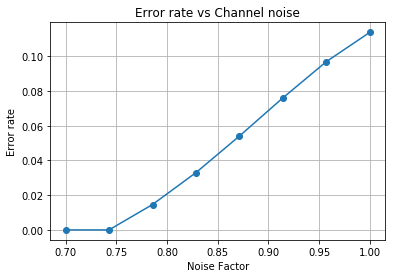

In [8]:
Noise = np.linspace(0.7,1,8)
bitsSize = np.linspace(1000,10000,10)
errorRates = []
keysLenght = []
errorMean = []
for q in Noise:
  for s in bitsSize:
    a = Alice()
    b = Bob()
    
    qbits = a.genQbits(int(s))
    p = density(qbits)
    t = transmission(p,q)
    b.measureQbits(t)
    compared = a.compareBasis(b.usedBasis)
    b.siftedKey(compared)
    index1,bits = a.errorCheck()
    res= b.errorCheck(index1,bits)
    errorRates.append(b.errorRate)
    keysLenght.append(len(b.siftedKey))
  errorMean.append(np.mean(np.array(errorRates)))
  
plt.plot(Noise,errorMean,'o-')
plt.xlabel('Noise Factor')
plt.ylabel('Error rate')
plt.title('Error rate vs Channel noise')
plt.grid(True)
plt.show()


## Key length vs Number of bits

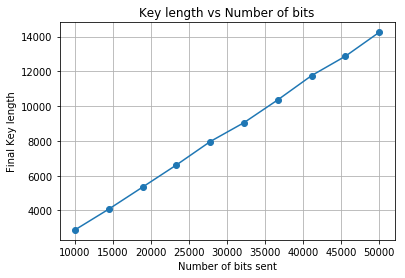

In [9]:

bitsSize = np.linspace(10000,50000,10)
keyslength = []
for s in bitsSize:
  a = Alice()
  b = Bob()

  qbits = a.genQbits(int(s))
  p = density(qbits)
  t = transmission(p,q)
  b.measureQbits(t)
  compared = a.compareBasis(b.usedBasis)
  b.siftedKey(compared)
  index1,bits = a.errorCheck()
  res= b.errorCheck(index1,bits)
  keyslength.append(len(b.siftedKey))
  
plt.plot(bitsSize,keyslength,'o-')
plt.xlabel('Number of bits sent')
plt.ylabel('Final Key length')
plt.title('Key length vs Number of bits')
plt.grid(True)
plt.show()

## Final key length vs Noise plot

In [0]:
Noise = Noise = np.linspace(0.5,1,30)
lenKey = []
for q in Noise: 
  ## System
  a = Alice()
  b = Bob()
  ## Alcie
  qbits = a.genQbits(int(100000))
  #Channel
  p = density(qbits)
  t = transmission(p,q)
  #Bob
  b.measureQbits(t)
  compared = a.compareBasis(b.usedBasis)
  b.siftedKey(compared)
  index1,bits = a.errorCheck()
  res= b.errorCheck(index1,bits)
  
  reconciliation(a,b)
  lenKey.append(len(b.siftedKey))

plt.plot(Noise,lenKey,'o-')
plt.xlabel('Noise Factor')
plt.ylabel('Key length')
plt.title('Final Key length vs Channel noise')
plt.grid(True)
plt.show()


# Conclusions

* Quantum Key Distribution procols are already viable and will be soon implemented world wide since it's based  in physics laws rather than in  some algorithm's computational complexity.
*  Quantum cryptography is still in development and needs the evolution of the physical layer in order to 100 % accomplish its purposes .
*  A large number of qubits must be sent in order to obtain a key lenght that could assure the confidentiality  fo the communication. This result can be verified with the simulation.

# References

[1] [The Security of Practical Quantum Key Distribution](https://arxiv.org/pdf/0802.4155.pdf )

[2]  [Hacking commercial quantum cryptography systems by tailored bright
illumination](https://arxiv.org/pdf/1008.4593.pdf)

[3] [An empirical analysis of the cascade secret key Reconciliation protocol for quantum key distribution](https://apps.dtic.mil/dtic/tr/fulltext/u2/a549804.pdf)

[4] [Security of differential phase shift quantum key distribution against individual attacks](https://arxiv.org/pdf/quant-ph/0508112.pdf)

[5] [Optimal realistic attacks in continuous-variable quantum key distribution](https://arxiv.org/pdf/1811.05562.pdf)

[6] [Security of Quantum Cryptography against Collective Attacks](http://www.cs.technion.ac.il/~qip-lab/publications/p2256_1.pdf)

[7] [Security of Quantum Key Distribution Against All Collective Attacks](https://arxiv.org/pdf/quant-ph/9801022.pdf)

[8] [Decoy State Quantum Key Distribution](https://arxiv.org/pdf/quant-ph/0411004.pdf)

[9][ Secret-Key Reconciliation by Public Discussion](https://link.springer.com/content/pdf/10.1007/3-540-48285-7_35.pdf)

[10] [ Incoherent and Coherent Eavesdropping in the 6-state Protocol of
Quantum Cryptography](https://arxiv.org/pdf/quant-ph/9807041.pdf)

[11][ A comparative study of protocols for secure quantum communication
under noisy environment: single-qubit-based protocols versus
entangled-state-based protocols](https://arxiv.org/pdf/1603.00178.pdf)

[12][ Cryptography from quantum mechanical viewpoint](https://arxiv.org/pdf/1407.2357.pdf)
